In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error

# Load dữ liệu từ file CSV (ví dụ)
df = pd.read_csv('D:\BID.csv')
df1=df.reset_index()['Price']
df1.describe

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]


# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_train.shape[1], 1)
X_train, y_train


(array([[[0.07418187],
         [0.06248662],
         [0.04786633],
         ...,
         [0.04786633],
         [0.04786633],
         [0.05078893]],
 
        [[0.06248662],
         [0.04786633],
         [0.05371396],
         ...,
         [0.04786633],
         [0.05078893],
         [0.05956159]],
 
        [[0.04786633],
         [0.05371396],
         [0.05225145],
         ...,
         [0.05078893],
         [0.05956159],
         [0.06394913]],
 
        ...,
 
        [[0.62946055],
         [0.63716491],
         [0.62946055],
         ...,
         [0.66412775],
         [0.64871902],
         [0.63908979]],
 
        [[0.63716491],
         [0.62946055],
         [0.62946055],
         ...,
         [0.64871902],
         [0.63908979],
         [0.64471353]],
 
        [[0.62946055],
         [0.62946055],
         [0.64486684],
         ...,
         [0.63908979],
         [0.64471353],
         [0.65688088]]]),
 array([0.05956159, 0.06394913, 0.0610241 , ..., 0.6447

In [3]:

# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(time_step, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=64)



Epoch 1/100

31/31 [==============================] - 1s 9ms/step - loss: 0.0177
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0026
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0023
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0023
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0023
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0022
Epoch 7/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 8/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 9/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 10/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 11/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0023
Epoch 12/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 13/100
31/31 [==============

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 256)           1024      
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 128)           98432     
                                                                 
 conv1d_2 (Conv1D)           (None, 24, 64)            24640     
                                                                 
 conv1d_3 (Conv1D)           (None, 22, 32)            6176      
                                                                 
 conv1d_4 (Conv1D)           (None, 20, 1)             97        
                                                                 
 global_average_pooling1d (  (None, 1)                 0         
 GlobalAveragePooling1D)                                         
                                                        

In [5]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
test_predict

15/15 [==============================] - 0s 3ms/step


array([[46434.004],
       [45573.03 ],
       [44793.617],
       [44539.164],
       [44907.434],
       [45499.746],
       [45299.83 ],
       [44083.598],
       [42994.44 ],
       [42207.266],
       [41418.375],
       [41016.54 ],
       [41169.594],
       [41276.66 ],
       [40983.156],
       [40052.273],
       [38936.92 ],
       [38673.156],
       [39571.54 ],
       [40631.414],
       [40950.406],
       [41016.043],
       [41429.72 ],
       [41823.785],
       [41490.36 ],
       [40799.543],
       [40526.555],
       [40718.016],
       [40769.605],
       [40538.375],
       [40965.945],
       [41889.312],
       [42374.688],
       [42661.57 ],
       [42862.53 ],
       [43086.08 ],
       [43300.434],
       [42765.38 ],
       [41641.812],
       [40747.   ],
       [40423.19 ],
       [39888.582],
       [38547.6  ],
       [37342.094],
       [36985.656],
       [37291.996],
       [37793.355],
       [37427.906],
       [36797.34 ],
       [36894.69 ],


In [6]:
# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(y_test[0], test_predict[:, 0]) * 100
test_score_mae =  mean_absolute_error(y_test[0], test_predict[:, 0])
msle = mean_squared_log_error(y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)
print('MSLE trên tập test là:', msle)


RMSE trên tập test là: 1632.2732672044053
MAPE trên tập test là: 3.3658774735383283 %
MAE trên tập test là: 1373.6798769194506
MSLE trên tập test là: 0.0016859841122158147


In [7]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = df1[-30:]
next_30_days = []
for i in range(30):
    x = last_30_days[-time_step:].reshape(1, time_step, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat, axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 [==============================] - 0s 26ms/step
[[38823.92 ]
 [38488.047]
 [37376.086]
 [37271.344]
 [38095.895]
 [38822.85 ]
 [39353.71 ]
 [39506.18 ]
 [39463.16 ]
 [39329.15 ]
 [38937.11 ]
 [38125.598]
 [37165.297]
 [36313.348]
 [35523.75 ]
 [34879.33 ]
 [34339.42 ]
 [33954.74 ]
 [33657.453]
 [33258.043]
 [32672.42 ]
 [32525.336]
 [33035.223]
 [33710.543]
 [34413.29 ]
 [34706.438]
 [34367.066]
 [33579.395]
 [32540.51 ]
 [31435.797]]


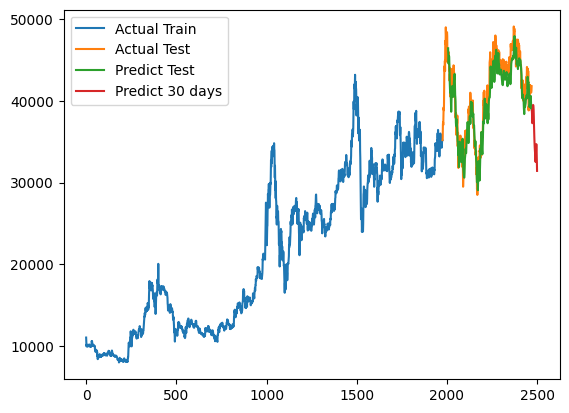

In [9]:
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#d62728', '#8c564b']
from matplotlib import pyplot as plt
# plt.figure(figsize=(12, 4))

# train

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label="Actual Train")
# plt.plot([*train_range], pred_train.squeeze(), label="Predict Train", linestyle="dotted", color = color_palette[1])

# test
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
# test_range = range(len(y_true_train.squeeze()),len(y_true_train.squeeze()) + len(y_true_test.squeeze()))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label="Actual Test")
test_data_index = pd.RangeIndex(start=train_size+31, stop=len(df1), step=1)
plt.plot(test_data_index, test_predict.squeeze(), label="Predict Test")


#30 days
prediect_data_index = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)
plt.plot(prediect_data_index, next_30_days.squeeze(), label="Predict 30 days",color = color_palette[4])

# # Dự đoán 30 điểm tiếp theo
plt.legend()
plt.show()